<a href="https://colab.research.google.com/github/Tony363/Chartmetric_Analysis/blob/master/Chartmetric_DataConsolidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Custom Functions

In [91]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import xgboost as xgb
import random
import plotly.express as px

from scipy import stats 
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler,StandardScaler,RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.decomposition import PCA
import itertools

# load in main database of songs and attributes
def load_data():
    df = pd.read_csv("Chartmetric_Sample_Data.csv")
    df.drop('Unnamed: 0',axis=1,inplace=True)
    df.set_index("Chartmetric_ID",inplace=True)# don't set index
    return df

# set some display options so easier to view all columns at once
def set_view_options(max_cols=50, max_rows=50, max_colwidth=9, dis_width=250):
    pd.options.display.max_columns = max_cols
    pd.options.display.max_rows = max_rows
    pd.set_option('max_colwidth', max_colwidth)
    pd.options.display.width = dis_width
    pd.option_context('mode.use_inf_as_na', True)
    
def rename_columns(df):
    # COMMENT
    subidx = [df.columns.get_loc(col) for col in df.columns if "Subject" in col] 
    subjects = df.columns[[subidx]]
    df.rename(columns={df.columns[subidx[idx]]:df.iloc[0,subidx[idx]] for idx,sub in enumerate(subidx)},inplace=True)
    for subject,idx in enumerate(range(0,len(df.columns),7)):
        # use 3 letter notations
        # hard code columns
        df.rename(columns={sub:df.columns[subidx[subject]]+"_"+sub for idx,sub in enumerate(df.columns[idx+1:idx+7])},inplace=True)
    return df

def get_df_info(df):
    # take an initial look at our data
    print(df.head(),'\n')

    # look at data types for each
    info = df.info()
    print(info,'\n')

    # take a look at data types, and it looks like we have a pretty clean data set!
    # However, I think the 0 popularity scores might throw the model(s) off a bit.
    print("Do we have any nulls?")
    print(f"Looks like we have {df.isnull().sum().sum()} nulls\n")
    
    subject_col = []
    statsdf = []
    # look at basic metric mapping
    for idx,col in enumerate(df.columns):
        if idx % 7 != 0:
            try:
                stats = df.agg({col:['min','max','median','mean','skew']})
                subject_col.append(col)
                statsdf.append(stats.transpose())
            except Exception as e:
                # print(e)
                continue
    statsdf = pd.concat(statsdf,axis=0,ignore_index=True)
    statsdf.set_index([pd.Index(subject_col)],inplace=True)
    return statsdf

# calculate and print more stats from the df
def get_stats(df):
    df.reset_index(inplace=True)
    # print stats for various metrics
    print()
    print(f"There are {df.shape[0]} rows")
    print(f"There are {df['Chartmetric_ID'].unique().shape} unique artists")
    print(f"There are {df['popularity value.1'].unique().shape} unique popularity scores")
    print(f"The mean popularity score is {df['popularity value.1'].mean()}")
    print(f"There are {df[df['popularity value.1'] > 55]['popularity value.1'].count()} songs with a popularity score > 55")
    print(f"There are {df[df['popularity value.1'] > 75]['popularity value.1'].count()} songs with a popularity score > 75")
    print(f"Only {(df[df['popularity value.1'] > 80]['popularity value.1'].count() / df.shape[0])*100:.2f} % of artists have a popularity score > 80")

def scale_grp(df,pct,time,cols):
    pct.replace([np.inf, -np.inf], np.nan,inplace=True)
    # no spaces
    df_std = pd.DataFrame(StandardScaler().fit_transform(pct),columns=['fx_followers','fx_popularity','fx_listeners','fx_ratio'])
    df_std['time_series'] = time
    df_std.set_index('time_series',inplace=True)
    df_norm = pd.DataFrame(MinMaxScaler().fit_transform(pct),columns=['fx_followers','fx_popularity','fx_listeners','fx_ratio'])
    df_norm['time_series'] = time
    df_norm.set_index('time_series',inplace=True)
    df_std_norm = pd.DataFrame(MinMaxScaler().fit_transform(df_std),columns=['fx_followers','fx_popularity','fx_listeners','fx_ratio'])
    print([col for col in df.columns if col in cols])
    print([col for col in df.columns if col not in cols])
    return df.loc[:,[col for col in df.columns if col in cols]],df.loc[:,[col for col in df.columns if col not in cols]],df_std,df_norm,df_std_norm

def group_time(df,groupby,cols):
    timeidx = [df.columns.get_loc(col) for col in df.columns if "timestp" in col] 
    time = df.iloc[:,timeidx]
    time = time.reset_index().loc[:,'followers_timestp']
    df = df.drop(df.columns[timeidx[1:]],axis=1)
    df.reset_index(inplace=True)
    df.fillna(method="ffill",inplace=True)
    df = df.groupby(groupby)[cols].first()
    df['fx_followers'] = df['followers_value'].pct_change()
    df['fx_popularity'] = df['popularity_value.1'].pct_change()
    df['fx_listeners'] = df['listeners_value.2'].pct_change()
    df['fx_ratio'] = df['followers_to_listeners_ratio_value.3'].pct_change()
    # separate artists and do fillna one artist at time
    # if artists don't have prev val fill with bfill
    df.fillna(method="ffill",inplace=True)
    pct = df.drop(cols,axis=1)
    return df,pct,time
   

def artist_diff_metric(df):
    timeidx = [df.columns.get_loc(col) for col in df.columns if "timestp" in col] 
    valueidx = [df.columns.get_loc(col) for col in df.columns if "value" in col or "ratio" in col] 
    df.drop(df.columns[timeidx+valueidx],axis=1,inplace=True)
    df.reset_index(inplace=True)
    artist_unique_row = [df.groupby('Chartmetric_ID').groups[artist][0] for artist in df.groupby('Chartmetric_ID').groups]
    df = df.loc[artist_unique_row,:].drop(['followers','popularity','listeners'],axis=1).set_index('Chartmetric_ID')
    return df.fillna(method="ffill")

def Multivariable_Matrix(df,original,col):
    cmatrix = []
    for shift,time in zip(range(df.shape[0]),df.index):
        cseries = df.loc[:,col].shift(-shift)
        smatrix = pd.DataFrame({f'shift_{shift}':cseries.values})
        cmatrix.append(smatrix)
    cmatrix = pd.concat(cmatrix,axis=1)
    cmatrix.drop(cmatrix.index[90:], inplace=True)
    cmatrix.index = original.index[:cmatrix.shape[0]]
    return cmatrix
    
def calc_correlations(df, cutoff=0.5):
    corr = df.corr()
    corr_data = corr[corr > cutoff]
    corr_list = df.corr().unstack().sort_values(kind="quicksort",ascending=False)
    return corr_list.where(corr_list < 1.0),corr_data

# nice way to truncate the column names to display easier
# can be used with various metrics
def describe_cols(df, L=10):
    '''Limit ENTIRE column width (including header)'''
    # get the max col width
    O = pd.get_option("display.max_colwidth")
    # set max col width to be L
    pd.set_option("display.max_colwidth", L)
    describe = df.rename(columns=lambda x: x[:L - 2] + '...' if len(x) > L else x).describe()
    pd.set_option("display.max_colwidth", O) 
    return describe

# get redundant pairs from DataFrame
def get_redundant_pairs(df):
    '''Get diagonal pairs of correlation matrix and all pairs we'll remove 
    (since pair each is doubled in corr matrix)'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            if df[cols[i]].dtype != 'object' and df[cols[j]].dtype != 'object':
                # print("THIS IS NOT AN OBJECT, YO, so you CAN take a corr of it, smarty!")
                pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    
    print("The top absolute correlations are:")
    print(au_corr[0:n])
    return au_corr[0:n]
    
# plot a scatter plot
def scatter_plot(df, col_x, col_y):
    plt.scatter(df[col_x], df[col_y], alpha=0.2)
    plt.title(f"{col_x} vs {col_y}")
    plt.xlabel(f"{col_x}")
    plt.ylabel(f"{col_y}")
    plt.show()

def plot_scatter_matrix(df, num_rows):
    scatter_matrix(df[:num_rows], alpha=0.2, figsize=(6, 6), diagonal='kde')
    plt.show()

# plot a heatmap of the correlations between features as well as dependent variable
def plot_heatmap(df):
    # note this looks better in jupyter as well
    plt.figure(figsize = (16,6))
    sns.heatmap(df.corr(), cmap="coolwarm", annot=True, )
    plt.show()
  
# plot a confusion matrix
def plot_confusion_matrix(cm, ax, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    font_size = 24
    p = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title,fontsize=font_size)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, fontsize=16)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=16)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if i == 1 and j == 1:
            lbl = "(True Positive)"
        elif i == 0 and j == 0:
            lbl = "(True Negative)"
        elif i == 1 and j == 0:
            lbl = "(False Negative)"
        elif i == 0 and j == 1:
            lbl = "(False Positive)"
        ax.text(j, i, "{:0.2f} \n{}".format(cm[i, j], lbl),
                 horizontalalignment="center", size = font_size,
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    ax.set_ylabel('True',fontsize=font_size)
    ax.set_xlabel('Predicted',fontsize=font_size)
    
# plot polularity scores distribution
def plot_pop_dist(df):
    # set palette
    sns.set_palette('muted')

    # create initial figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    sns.distplot(df['popularity_value.1']/100, color='g', label="Popularity").set_title("Distribution of Popularity Scores - Entire Data Set")

    # create x and y axis labels
    plt.xlabel("Popularity")
    plt.ylabel("Density")

    plt.show()

# plot undersampling methodology
def undersample_plot(df):
    # set palette
    sns.set_palette('muted')

    # create initial figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    sns.distplot(df['popularity_value.1']/100, color='g', label="Popularity").set_title("Illustration of Undersampling from Data Set")
    
    # create line to shade to the right of
    line = ax.get_lines()[-1]
    x_line, y_line = line.get_data()
    mask = x_line > 0.55
    x_line, y_line = x_line[mask], y_line[mask]
    ax.fill_between(x_line, y1=y_line, alpha=0.5, facecolor='red')

    # get values for and plot first label
    label_x = 0.5
    label_y = 4
    arrow_x = 0.6
    arrow_y = 0.2

    arrow_properties = dict(
        facecolor="black", width=2,
        headwidth=4,connectionstyle='arc3,rad=0')

    plt.annotate(
        "First, sample all popularity value in this range.\n Sample size is n. Cutoff is 0.5.", xy=(arrow_x, arrow_y),
        xytext=(label_x, label_y),
        bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=0.5),
        arrowprops=arrow_properties)

    # Get values for and plot second label
    label_x = 0.1
    label_y = 3
    arrow_x = 0.2
    arrow_y = 0.2

    arrow_properties = dict(
        facecolor="black", width=2,
        headwidth=4,connectionstyle='arc3,rad=0')

    plt.annotate(
        "Next, randomly sample \n n popularity value in this range", xy=(arrow_x, arrow_y),
        xytext=(label_x, label_y),
        bbox=dict(boxstyle='round,pad=0.5', fc='g', alpha=0.5),
        arrowprops=arrow_properties)

    # plot final word box
    plt.annotate(
        "Therefore, end up with a 50/50 \n split of Popular / Not Popular\n artist", xy=(0.6, 2),
        xytext=(0.62, 2),
        bbox=dict(boxstyle='round,pad=0.5', fc='b', alpha=0.5))

    # create x and y axis labels
    plt.xlabel("Popularity")
    plt.ylabel("Density")

    plt.show()

# plot univariate dists for several independent variables
def plot_univ_dists(df, cutoff):
    popularity_cutoff = cutoff
    print('Mean value for followers feature for Popular artists: {}'.format(df[df['popularity_value.1'] > popularity_cutoff]['followers_value'].mean()))
    print('Mean value for followers feature for Unpopular artists: {}'.format(df[df['popularity_value.1'] < popularity_cutoff]['followers_value'].mean()))
    print('Mean value for listeners feature for Popular artists: {}'.format(df[df['popularity_value.1'] > popularity_cutoff]['listeners_value.2'].mean()))
    print('Mean value for listeners feature for Unpopular artists: {}'.format(df[df['popularity_value.1'] < popularity_cutoff]['listeners_value.2'].mean()))
  
    
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    fig.suptitle('Histograms and Univariate Distributions of Important Features')
    sns.distplot(df[df['popularity_value.1'] < popularity_cutoff]['followers_value'])
    sns.distplot(df[df['popularity_value.1'] > popularity_cutoff]['followers_value'])
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    sns.distplot(df[df['popularity_value.1'] < popularity_cutoff]['listeners_value.2'])
    sns.distplot(df[df['popularity_value.1'] > popularity_cutoff]['listeners_value.2'])
    plt.show()

def validation_plot(y_test, pred_test):
    """
    Parameters
    ----------
    y_test : validation set.
    pred_test : prediction on test.

    Returns
    -------
    None.

    """
    fig, ax = plt.subplots()
    ax.scatter(y_test, pred_test, color="b")
    # ax.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'k--',lw=4)
    ax.set_xlabel("preds")
    ax.set_ylabel("y_test")
    ax.set_title("validate on pred")
    plt.show()


# choose cutoff, sample popular data, randomly sample unpopular data, and combine the dfs
def split_sample_combine(df, cutoff, col='fx_popularity', rand=None):
    # split out popular rows above the popularity cutoff
    split_pop_df = df[df[col] >= cutoff].copy()

    # get the leftover rows, the 'unpopular' songs
    df_leftover = df[df[col] < cutoff].copy()

    # what % of the original data do we now have?
    ratio = split_pop_df.shape[0] / df.shape[0]
    
    # what % of leftover rows do we need?
    ratio_leftover = split_pop_df.shape[0] / df_leftover.shape[0]

    # get the exact # of unpopular rows needed, using a random sampler
    unpop_df_leftover, unpop_df_to_add = train_test_split(df_leftover, \
                                                          test_size=ratio_leftover, \
                                                          random_state = rand)
    
    # combine the dataframes to get total rows = split_pop_df * 2
    # ssc stands for "split_sample_combine"
    ssc_df = split_pop_df.append(unpop_df_to_add).reset_index(drop=True)

    # shuffle the df
    ssc_df = ssc_df.sample(frac=1, random_state=rand).reset_index(drop=True)
    
    # add columns relating to popularity
    ssc_df['pop_frac'] = ssc_df[col] / 100
    ssc_df['pop_cat'] = np.where(ssc_df[col] > cutoff, "Popular", "Not_Popular")
    ssc_df['pop_bin'] = np.where(ssc_df[col] > cutoff, 1, 0)
    return ssc_df

# initial linear regression function, and plots
def linear_regression_initial(df,features,Y):
    df = df.copy()
    X = df[features]
    plot_title = (Y) if len(features) > 1 else (Y,features)
    y_col = [Y]
    y = df[y_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    X_train = sm.add_constant(X_train)
    # Instantiate OLS model, fit, predict, get errors
    model = sm.OLS(y_train, X_train)
    results = model.fit()
    fitted_vals_train = results.predict(X_train)
    stu_resid = results.resid_pearson
    residuals = results.resid
    y_vals = pd.DataFrame({'residuals':residuals, 'fitted_vals':fitted_vals_train, \
                            'stu_resid': stu_resid})

    # Print the results
    print(results.summary())

    # QQ Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.title(f"QQ Plot {plot_title} of OLS")
    fig = sm.qqplot(stu_resid, line='45', fit=True, ax=ax)
    plt.show()

    # validate pred
    validation_plot(y_train, fitted_vals_train)

    # Residuals Plot
    y_vals.plot(kind='scatter', x='fitted_vals', y='stu_resid')
    plt.title(f"{plot_title} regression")
    plt.show()
    return y_vals

def lin_reg_forcast(df,Y,PARAMETERS = {
        'max_depth':20,
        'min_child_weight': 5,
        'eta':.1,
        'subsample': .7,
        'colsample_bytree': .7,
        'nthread':-1,
        'objective':'reg:squarederror',
        'eval_metric':'rmse'
    }):
    df = df.copy()
    X_cols = df.columns.drop(Y)

    y_col = [Y]

    X = df[X_cols]
    y = df[y_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    dtrain = xgb.DMatrix(X_train, y_train,nthread=-1)
    dtest = xgb.DMatrix(X_test, y_test,nthread=-1)

    bst = xgb.train(
        params=PARAMETERS,
        dtrain=dtrain,
        # num_boost_round=999,
        # evals=[(dtest,"Test")],
        # early_stopping_rounds=10,
        )
    pred_test = bst.predict(dtrain)
    pred_leaf = bst.predict(dtrain,pred_leaf=True)
    print(pred_leaf)
    return pred_test

# Create a basic logistic regression
def basic_logistic_regression(df, cutoff,col='pop_bin', rand=0, sig_only=False):
    df = df.copy()
    X, y = return_X_y_logistic(split_sample_combine(df, cutoff,col, rand=rand))
    X = standardize_X(X)
    X_const = add_constant(X, prepend=True)
    print("X_const\n",X_const)
    print("Y\n",y)
    
    logit_model = Logit(y, X_const).fit(solver='lbfgs',skip_hessian=True,max_iter=20000)
    
    print(logit_model.summary())

    return logit_model

def logistic_regression_with_kfold(df, cutoff=2.682048, rand=0, sig_only=False):
    df = df.copy()
    
    if sig_only == True:
        X, y = return_X_y_logistic_sig_only(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X_sig_only(X)

    else:
        X, y = return_X_y_logistic(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X(X)

    X = X.values
    y = y.values.ravel()

    classifier = LogisticRegression()

    # before kFold
    y_predict = classifier.fit(X, y).predict(X)
    y_true = y
    accuracy_score(y_true, y_predict)
    print(f"accuracy: {accuracy_score(y_true, y_predict)}")
    print(f"precision: {precision_score(y_true, y_predict)}")
    print(f"recall: {recall_score(y_true, y_predict)}")
    print(f"The coefs are: {classifier.fit(X,y).coef_}")

    # with kfold
    kfold = KFold(len(y))

    accuracies = []
    precisions = []
    recalls = []

    for train_index, test_index in kfold:
        model = LogisticRegression()
        model.fit(X[train_index], y[train_index])

        y_predict = model.predict(X[test_index])
        y_true = y[test_index]

        accuracies.append(accuracy_score(y_true, y_predict))
        precisions.append(precision_score(y_true, y_predict))
        recalls.append(recall_score(y_true, y_predict))

    print(f"accuracy: {np.average(accuracies)}")
    print(f"precision: {np.average(precisions)}")
    print(f"recall: {np.average(recalls)}")

def Principal_Comp_Reg(df,features,Y,Standardize=False,n_components=2):
    pca = PCA(n_components=n_components)
    # Separating out the features
    x = df.loc[:,features].values
    # Separating out the target
    y = df.loc[:,[Y]].values
    if Standardize:
        # Standardizing the features
        x = StandardScaler().fit_transform(x)
    principalComponents = np.hstack((pca.fit_transform(x),y))
    principaldf = pd.DataFrame(principalComponents,columns=[f"P{i}" for i in range(n_components)]+[Y])

    labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }

    fig = px.scatter_matrix(
        principalComponents,
        labels=labels,
        dimensions=range(3),
        color=df[Y]
    )
    fig.update_traces(diagonal_visible=False)
    fig.show()
    return principaldf,pca.explained_variance_ratio_

def Visualize_PCA(df,features,Y,cluster_range=0.2):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)

    colors = ['r', 'g', 'b']

    for feature, color in zip(features,colors):
        ax.scatter(df.loc[(df[feature] > df[Y]-cluster_range) & (df[feature] < df[Y]+cluster_range),'P0']
                , df.loc[(df[feature] > df[Y]-cluster_range) & (df[feature] < df[Y]+cluster_range),'P1']
                , c = color
                , s = 50)
    ax.legend(features)
    ax.grid()

def Kmeans_elbow(X):
    wcss = []
    for i in range(1,11):
        kmeans = KMeans(n_clusters=i,init='k-means++',random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10,5))
    sns.lineplot(range(1, 11), wcss,marker='o',color='red')
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Fitting K-Means to the dataset
    kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
    y_kmeans = kmeans.fit_predict(X)
    return y_kmeans,kmeans

def Kmeans_Viz(X,y_kmeans,kmeans):
    # Visualising the clusters
    plt.figure(figsize=(15,7))
    sns.scatterplot(X.iloc[y_kmeans == 0, 0], X.iloc[y_kmeans == 0, 1], color = 'yellow', label = 'Cluster 1',s=50)
    sns.scatterplot(X.iloc[y_kmeans == 1, 0], X.iloc[y_kmeans == 1, 1], color = 'blue', label = 'Cluster 2',s=50)
    sns.scatterplot(X.iloc[y_kmeans == 2, 0], X.iloc[y_kmeans == 2, 1], color = 'green', label = 'Cluster 3',s=50)
    sns.scatterplot(X.iloc[y_kmeans == 3, 0], X.iloc[y_kmeans == 3, 1], color = 'grey', label = 'Cluster 4',s=50)
    sns.scatterplot(X.iloc[y_kmeans == 4, 0], X.iloc[y_kmeans == 4, 1], color = 'orange', label = 'Cluster 5',s=50)
    sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color = 'red', 
                    label = 'Centroids',s=300,marker=',')
    plt.grid(False)
    plt.title('Clusters of customers')
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending Score (1-100)')
    plt.legend()
    plt.show()

# various data standardization and X/y split functions for logisitic reression
# based on the columns you want to standardize and return
def return_X_y_logistic(df):
    df = df.copy()

    # define columns to use for each
    X_cols = ['fx_followers','fx_listeners','fx_ratio','pop_frac']

    # use 1's and 0's for logistic
    y_col = 'pop_bin'

    # split into X and y
    X = df[X_cols]
    y = df[y_col]

    return X, y

def standardize_X(X):  
    X = X.copy()
    
    # standardize only columns not between 0 and 1
    for col in ['fx_followers','fx_listeners','fx_ratio','fx_popularity','pop_frac']:
        new_col_name = col + "_std"
        X[new_col_name] = (X[col] - X[col].mean()) / X[col].std()
        
    X_cols = ['fx_followers_std','fx_popularity_std','fx_listeners_std','fx_ratio_std','pop_frac_std']

    # return the std columns in a dataframe
    X = X[X_cols]
    
    return X





# Chartmetric Data Exploratory Analysis

### Metric Index

[Followers](https://artists.spotify.com/faq/stats#who-are-followers)

[Monthly Listeners](https://artists.spotify.com/faq/stats#who-are-monthly-listeners)

**Popularity** --- The "popularity" of the artist. The value will be between 0 and 100, with 100 being the most popular. The metric is calculated by an algorithm, and is based on the number of listens/plays the artist receives and weighted by how recent those plays are.

[Further Metric Explanation]( https://nnnehasingh15.medium.com/spotify-monthly-listeners-and-spotify-streams-explained-ba3752e9b872)

### Objective
Create new metric(artist score) off of popularity, followers, listeners <- these 3 variables for now
Then deploy adhoc dashboard(UI)
- with plot metrics
- anything now is to be barebones for minimal viable product
- proof of concept first <- small easy project, easy money

### Methods to Explore
- forcasting followers and listeners over 6 month regression
    - *Optional Cutoff*
        - followers lower than 10000
        - listeners lower than 100000
        - popularity cut off, below 40
- Pair feature regression
- Simple Logistic regression on relevant non relevant artists [(having issues to converge after 35 iteration)](https://stackoverflow.com/questions/52670012/convergencewarning-liblinear-failed-to-converge-increase-the-number-of-iterati)
- heuristics weighted time series on axis of average and aggregate
- aggregate difference of metrics divided by mean
- Principle Component regression 
- Principle Component Analysis 
- Clustering to see which artists are in relevant cluster and which arn't
- ridge regression
- elastic net 
- apply logarthmic EDA to discover popularity
- Y value on weekly, monthly diff and perform values



### References
- [Build predictive Business Intelligence with Google Colab, Google Data Studio and Google Sheets](https://towardsdatascience.com/build-predictive-business-intelligence-with-google-colab-google-data-studio-and-google-sheets-9a5c1559124f)
- [How to Import and Export Datasets in Google Colab](https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971)
- [Colab and Google Sheets -- Surprisingly Powerful Combination for Data Science](https://medium.com/analytics-vidhya/colab-and-google-sheets-surprisingly-powerful-combination-for-data-science-part-1-bbbb11cbd8e)
- [ MattD82 /
Predicting-Spotify-Song-Popularity ](https://github.com/MattD82/Predicting-Spotify-Song-Popularity)
    - [On Kaggle](https://www.kaggle.com/tomigelo/spotify-audio-features?select=SpotifyAudioFeaturesApril2019.csv)
- [Principal Component Regression(unsupervised)](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)


### Clean data

In [92]:
# data clean
df = load_data()  
set_view_options(max_cols=50, max_rows=50, max_colwidth=40, dis_width=250)
duplicated = True in df.columns.duplicated()
print(f"duplicate columns: {duplicated}\n")
df = rename_columns(df)

# only time series
groupby = ['followers_timestp']
cols = ['followers_value','popularity_value.1','listeners_value.2','followers_to_listeners_ratio_value.3']
grp,pct,time = group_time(df,groupby,cols)
grp,cr,cr_std,cr_norm,cr_stdnorm = scale_grp(grp,pct,time,cols)

# sort by ID and time series
groupby = ['Chartmetric_ID','followers_timestp']
cols = ['followers_value','popularity_value.1','listeners_value.2','followers_to_listeners_ratio_value.3']
grped,pct,time = group_time(df,groupby,cols)
grped,cr,cr_std,cr_norm,cr_stdnorm = scale_grp(grped,pct,time,cols)

grp.to_csv("grouped.csv")
cr.to_csv("change_rate.csv")
cr_std.to_csv("change_rate_standardized.csv")
cr_norm.to_csv("change_rate_normalized.csv")
cr_stdnorm.to_csv("change_rate_standardized.csv")

duplicate columns: False

['followers_value', 'popularity_value.1', 'listeners_value.2', 'followers_to_listeners_ratio_value.3']
['fx_followers', 'fx_popularity', 'fx_listeners', 'fx_ratio']
['followers_value', 'popularity_value.1', 'listeners_value.2', 'followers_to_listeners_ratio_value.3']
['fx_followers', 'fx_popularity', 'fx_listeners', 'fx_ratio']


/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



#### Unique artist difference df

In [93]:
artist_diff = artist_diff_metric(df)
artist_diff.to_csv("artist_diff.csv")
artist_diff.head()

,followers_weekly_diff,followers_weekly_diff_percent,followers_monthly_diff,followers_monthly_diff_percent,popularity_weekly_diff.1,popularity_weekly_diff_percent.1,popularity_monthly_diff.1,popularity_monthly_diff_percent.1,listeners_weekly_diff.2,listeners_weekly_diff_percent.2,listeners_monthly_diff.2,listeners_monthly_diff_percent.2
Chartmetric_ID,,,,,,,,,,,,
20syl,229.0,0.2300,844.0,0.8528,0.0,0.0,0.0,0.000,2.0,0.0005,-10314.0,-2.7009
21 Savage,21294.0,0.2467,60223.0,0.7008,0.0,0.0,-1.0,-1.087,-1117492.0,-5.0836,755915.0,3.7591
3 Um Só,919.0,0.4898,3979.0,2.1559,0.0,0.0,0.0,0.000,-877.0,-1.4909,-5141.0,-8.1489
311,2006.0,0.3026,8028.0,1.2223,0.0,0.0,0.0,0.000,-57382.0,-2.6298,-103150.0,-4.6303
4Minute,2497.0,0.3009,10040.0,1.2208,0.0,0.0,0.0,0.000,-4480.0,-0.8333,-20107.0,-3.6342


### Unique artist Principal Component Analysis




In [94]:
artist_PCA,explained_ratio = Principal_Comp_Reg(artist_diff,artist_diff.columns.drop('popularity_monthly_diff.1'),'popularity_monthly_diff.1',Standardize=True)

In [95]:
artist_PCA

,P0,P1,popularity_monthly_diff.1
0,0.428314,-0.385443,0.0
1,-2.826776,5.509518,-1.0
2,0.116903,0.073321,0.0
3,0.045202,0.342714,0.0
4,-0.029599,0.224150,0.0
...,...,...,...
252,0.488253,-0.439426,0.0
253,0.001176,0.345153,1.0
254,0.248050,-0.112366,0.0
255,0.446860,-0.366180,0.0


In [96]:
explained_ratio

array([0.22799583, 0.18551205])

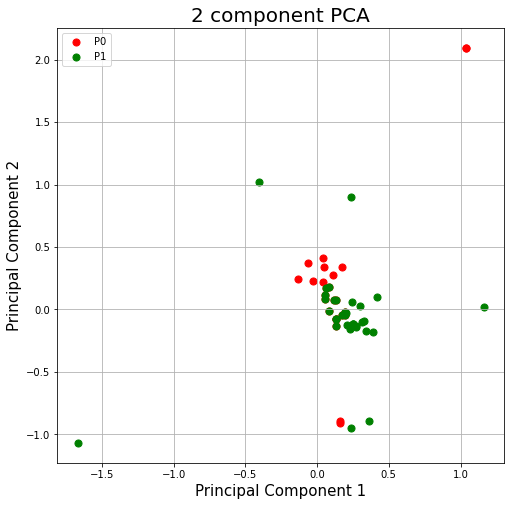

In [97]:
Visualize_PCA(artist_PCA,artist_PCA.columns.drop('popularity_monthly_diff.1'),'popularity_monthly_diff.1')

### Principal Component Regression with groupby timeseries 

In [98]:
time_PCA,explained_ratio = Principal_Comp_Reg(grp,grp.columns.drop('popularity_value.1'),'popularity_value.1',n_components=3)

In [99]:
# still need to reverse PCA to get meaning of chart
time_PCA

,P0,P1,P2,popularity_value.1
0,1.334825e+06,5473.122704,-93.176001,3.0
1,-1.389030e+05,-720.667326,20.341263,61.0
2,1.334828e+06,5473.504562,-97.475380,3.0
3,-1.534723e+05,-2322.893576,17.644775,62.0
4,1.334822e+06,5471.748468,-88.497513,3.0
...,...,...,...,...
148,-3.520272e+05,-11475.169879,-8.573176,60.0
149,-3.520272e+05,-11475.169879,-8.573176,60.0
150,-3.804494e+05,-14398.145691,-13.703748,60.0
151,-3.804494e+05,-14398.145691,-13.703748,60.0


In [100]:
explained_ratio

array([9.99559439e-01, 4.40557161e-04, 3.69821051e-09])

                            OLS Regression Results                            
Dep. Variable:     popularity_value.1   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2014.
Date:                Tue, 29 Dec 2020   Prob (F-statistic):          3.94e-101
Time:                        07:25:16   Log-Likelihood:                -310.66
No. Observations:                 122   AIC:                             629.3
Df Residuals:                     118   BIC:                             640.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.9124      0.288    173.573      0.0

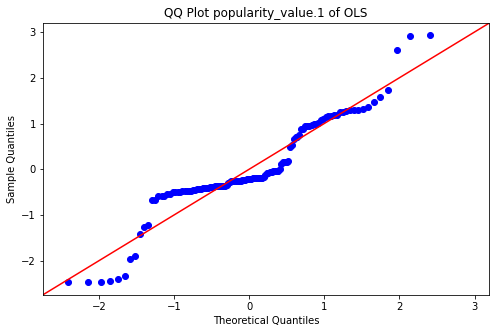

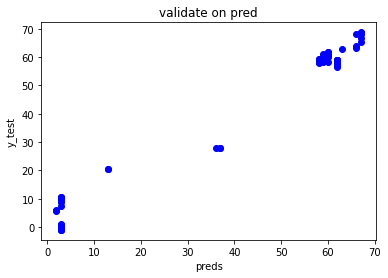

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


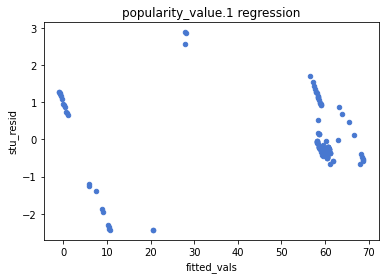

In [101]:
# if LSTM generate batches by artist
# Tree based methods generate integer ID for artist
time_pca_reg = linear_regression_initial(time_PCA,time_PCA.columns.drop('popularity_value.1'),Y='popularity_value.1')

### Principal Component Regression with groupby Chartmetric ID and timeseries 

In [102]:
grp_PCA,explained_ratio = Principal_Comp_Reg(grped,grped.columns.drop('popularity_value.1'),'popularity_value.1',n_components=3)

In [103]:
grp_PCA

,P0,P1,P2,popularity_value.1
0,-1.315241e+06,4427.444198,-939.569139,56.0
1,-1.313827e+06,4904.986670,-939.352529,56.0
2,-1.316063e+06,4044.698004,-939.685938,56.0
3,-1.318101e+06,3239.845508,-939.982467,56.0
4,-1.320298e+06,2386.292046,-940.299356,56.0
...,...,...,...,...
19891,-1.740119e+06,-59928.212972,-946.159542,7.0
19892,-1.740105e+06,-59933.383388,-946.188195,8.0
19893,-1.740055e+06,-59924.673326,-949.729786,9.0
19894,-1.740049e+06,-59899.752378,-953.255041,8.0


In [104]:
explained_ratio

array([9.57800595e-01, 4.21851737e-02, 1.42309812e-05])

                            OLS Regression Results                            
Dep. Variable:     popularity_value.1   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     3691.
Date:                Tue, 29 Dec 2020   Prob (F-statistic):               0.00
Time:                        07:25:17   Log-Likelihood:                -66290.
No. Observations:               15916   AIC:                         1.326e+05
Df Residuals:                   15912   BIC:                         1.326e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.1813      0.124    414.344      0.0

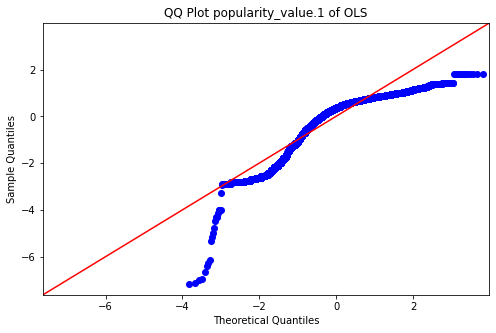

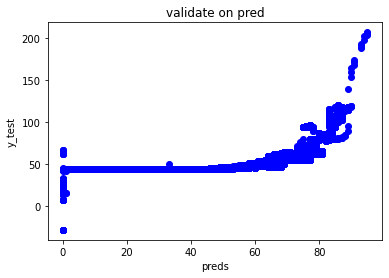

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


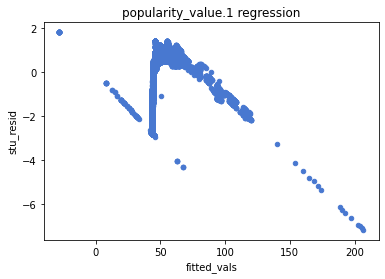

In [105]:
pca_reg = linear_regression_initial(grp_PCA,grp_PCA.columns.drop('popularity_value.1'),Y='popularity_value.1')

no significant clustering findings



### KMeans Clustering of PCA

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



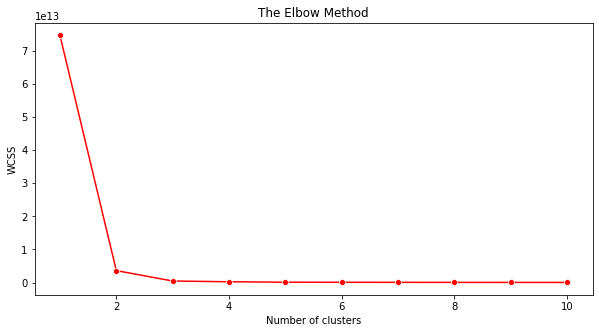

In [106]:
y_kmeans,kmeans = Kmeans_elbow(time_PCA)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



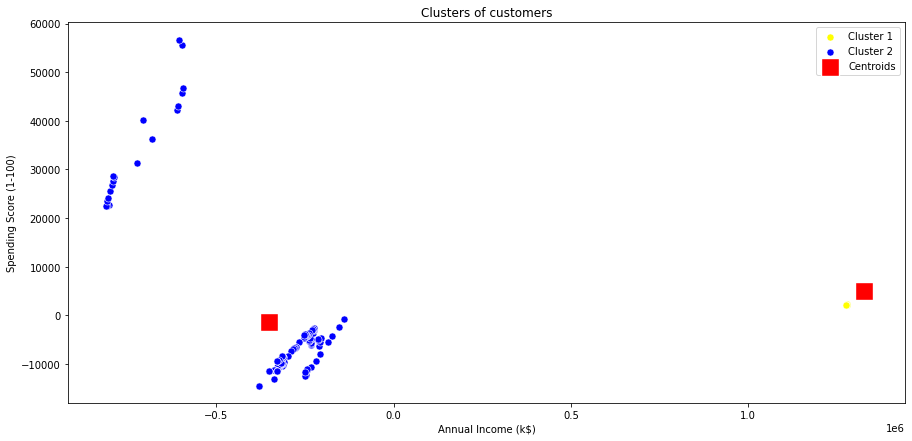

In [107]:
Kmeans_Viz(time_PCA,y_kmeans,kmeans)
# 

### Prelim Insights

#### Artist Unique monthly, weekly differences

In [108]:
get_df_info(artist_diff)

                followers_weekly_diff  followers_weekly_diff_percent  followers_monthly_diff  followers_monthly_diff_percent  popularity_weekly_diff.1  popularity_weekly_diff_percent.1  popularity_monthly_diff.1  popularity_monthly_diff_percent.1  \
Chartmetric_ID                                                                                                                                                                                                                                           
20syl                           229.0                         0.2300                   844.0                          0.8528                       0.0                               0.0                        0.0                              0.000   
21 Savage                     21294.0                         0.2467                 60223.0                          0.7008                       0.0                               0.0                       -1.0                             -1.087   


,min,max,median,mean,skew
followers_weekly_diff_percent,-4.220000e-02,2.525300e+00,0.2575,0.336888,2.594009
followers_monthly_diff,-9.000000e+00,1.498370e+05,179.0000,5913.879377,4.889820
followers_monthly_diff_percent,-5.555600e+00,1.578950e+01,1.1390,1.522076,3.386155
popularity_weekly_diff.1,-2.000000e+00,1.000000e+00,0.0000,0.120623,1.051905
popularity_weekly_diff_percent.1,-8.333300e+00,8.333300e+00,0.0000,0.158216,-2.300475
popularity_monthly_diff.1,-3.000000e+00,1.200000e+01,0.0000,0.322957,5.368643
listeners_weekly_diff.2,-1.117492e+06,1.203116e+06,-32.0000,-8076.276265,0.706944
listeners_weekly_diff_percent.2,-2.500000e+01,3.846150e+01,-0.6168,0.138477,2.469842
listeners_monthly_diff.2,-2.026390e+06,2.611250e+06,-55.0000,7574.560311,2.537831
listeners_monthly_diff_percent.2,-6.836100e+01,2.756009e+03,-2.4439,11.570715,15.593532


#### Change Rate Standardized

In [109]:
cr_std = cr_std.iloc[1:,:]
get_df_info(cr_std)

                          fx_followers  fx_popularity  fx_listeners  fx_ratio
time_series                                                                  
2020-01-04T00:00:00.000Z     -0.013455      -0.011476     -0.007664 -0.010401
2020-01-08T00:00:00.000Z     -0.013455      -0.011476     -0.007664 -0.010026
2020-01-10T00:00:00.000Z     -0.013455      -0.011476     -0.007664 -0.010028
2020-01-14T00:00:00.000Z     -0.013455      -0.011476     -0.007664 -0.010009
2020-01-16T00:00:00.000Z     -0.013455      -0.011476     -0.007664 -0.010133 

<class 'pandas.core.frame.DataFrame'>
Index: 19895 entries, 2020-01-04T00:00:00.000Z to 2020-06-01T00:00:00.000Z
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fx_followers   19895 non-null  float64
 1   fx_popularity  19865 non-null  float64
 2   fx_listeners   19895 non-null  float64
 3   fx_ratio       19895 non-null  float64
dtypes: float64(4)
memory usage: 777.1+ KB


,min,max,median,mean,skew
fx_popularity,-1.056882,66.894492,-0.011476,-2.062040e-15,49.467752
fx_listeners,-0.007668,140.894565,-0.007664,2.599883e-16,140.606723
fx_ratio,-0.054210,140.263226,-0.010276,-1.654347e-16,138.782134


#### Change Rate Normalized

In [110]:
get_df_info(cr_norm)

                          fx_followers  fx_popularity  fx_listeners  fx_ratio
time_series                                                                  
2020-01-02T00:00:00.000Z           NaN            NaN           NaN       NaN
2020-01-04T00:00:00.000Z  8.512220e-07       0.015385  2.670832e-08  0.000312
2020-01-08T00:00:00.000Z  8.510023e-07       0.015385  2.646343e-08  0.000315
2020-01-10T00:00:00.000Z  8.511644e-07       0.015385  2.647548e-08  0.000315
2020-01-14T00:00:00.000Z  8.510689e-07       0.015385  2.646420e-08  0.000315 

<class 'pandas.core.frame.DataFrame'>
Index: 19896 entries, 2020-01-02T00:00:00.000Z to 2020-06-01T00:00:00.000Z
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fx_followers   19895 non-null  float64
 1   fx_popularity  19865 non-null  float64
 2   fx_listeners   19895 non-null  float64
 3   fx_ratio       19895 non-null  float64
dtypes: float64(4)
memory usage: 777.2+ KB


,min,max,median,mean,skew
fx_popularity,0.0,1.0,1.538462e-02,0.015554,49.467752
fx_listeners,0.0,1.0,2.661415e-08,0.000054,140.606723
fx_ratio,0.0,1.0,3.130980e-04,0.000386,138.782134


#### Change Rate Standardized then Normalized because

In [111]:
cr_stdnorm = cr_stdnorm.iloc[1:,:]
get_df_info(cr_stdnorm) 

   fx_followers  fx_popularity  fx_listeners  fx_ratio
1  8.512220e-07       0.015385  2.670832e-08  0.000312
2  8.510023e-07       0.015385  2.646343e-08  0.000315
3  8.511644e-07       0.015385  2.647548e-08  0.000315
4  8.510689e-07       0.015385  2.646420e-08  0.000315
5  8.509734e-07       0.015385  2.652982e-08  0.000314 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19895 entries, 1 to 19895
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fx_followers   19895 non-null  float64
 1   fx_popularity  19865 non-null  float64
 2   fx_listeners   19895 non-null  float64
 3   fx_ratio       19895 non-null  float64
dtypes: float64(4)
memory usage: 621.8 KB
None 

Do we have any nulls?
Looks like we have 30 nulls



,min,max,median,mean,skew
fx_popularity,0.0,1.0,1.538462e-02,0.015554,49.467752
fx_listeners,0.0,1.0,2.661415e-08,0.000054,140.606723
fx_ratio,0.0,1.0,3.130980e-04,0.000386,138.782134


#### Group by Chartmetric ID and then Timeseries. 
- Did ffill for nans

In [112]:
get_df_info(grp)

                          followers_value  popularity_value.1  listeners_value.2  followers_to_listeners_ratio_value.3
followers_timestp                                                                                                     
2020-01-01T00:00:00.000Z            509.0                 3.0              190.0                                267.89
2020-01-02T00:00:00.000Z         180028.0                61.0          1462956.0                                 12.31
2020-01-03T00:00:00.000Z            509.0                 3.0              187.0                                272.19
2020-01-04T00:00:00.000Z         180274.0                62.0          1477611.0                                 12.20
2020-01-05T00:00:00.000Z            508.0                 3.0              193.0                                263.21 

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 2020-01-01T00:00:00.000Z to 2020-06-01T00:00:00.000Z
Data columns (total 4 columns):
 #   Column           

,min,max,median,mean,skew
popularity_value.1,2.00,67.00,59.00,4.983007e+01,-1.562816
listeners_value.2,162.00,2127363.00,1577972.00,1.325069e+06,-1.254605
followers_to_listeners_ratio_value.3,7.65,273.66,12.04,4.616562e+01,2.072831


#### initial target is grouped by Chartmetric ID and Timeseries

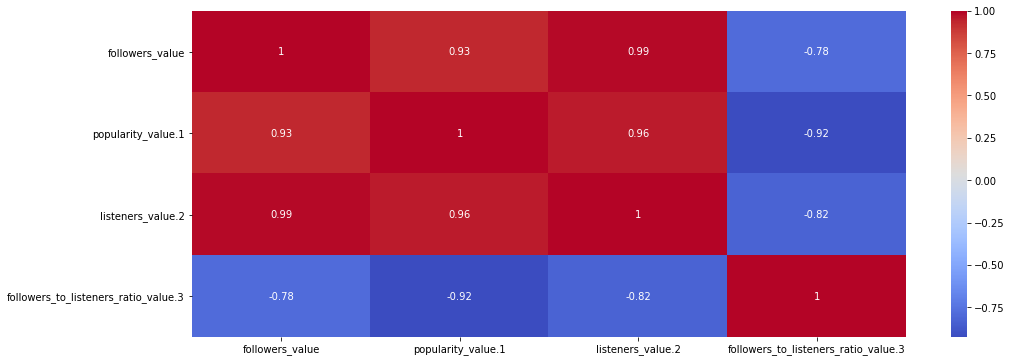

In [113]:
plot_heatmap(grp)

#### Find Highly correlated metrics to list and dataframe

In [114]:
# Find Highly correlated metrics to list and dataframe
corr_list,corr_data = calc_correlations(grp)
corr_list

followers_to_listeners_ratio_value.3  followers_to_listeners_ratio_value.3         NaN
listeners_value.2                     listeners_value.2                            NaN
popularity_value.1                    popularity_value.1                           NaN
followers_value                       followers_value                              NaN
listeners_value.2                     followers_value                         0.986171
followers_value                       listeners_value.2                       0.986171
listeners_value.2                     popularity_value.1                      0.961009
popularity_value.1                    listeners_value.2                       0.961009
                                      followers_value                         0.933103
followers_value                       popularity_value.1                      0.933103
followers_to_listeners_ratio_value.3  followers_value                        -0.784836
followers_value                       follo

In [115]:
corr_data

,followers_value,popularity_value.1,listeners_value.2,followers_to_listeners_ratio_value.3
followers_value,1.000000,0.933103,0.986171,NaN
popularity_value.1,0.933103,1.000000,0.961009,NaN
listeners_value.2,0.986171,0.961009,1.000000,NaN
followers_to_listeners_ratio_value.3,NaN,NaN,NaN,1.0


##### Pair Regression Exploration

#### Plot pair relationship of correlated metrics greater than 0.5

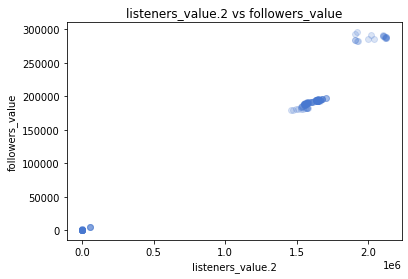

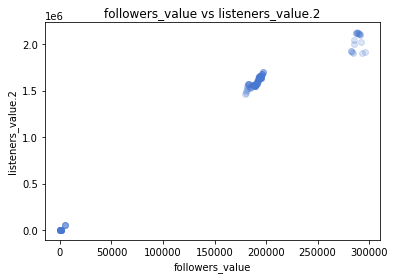

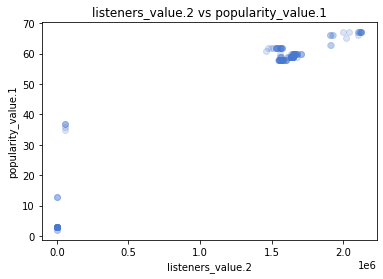

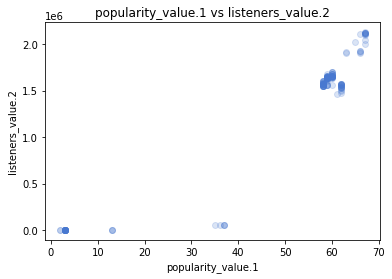

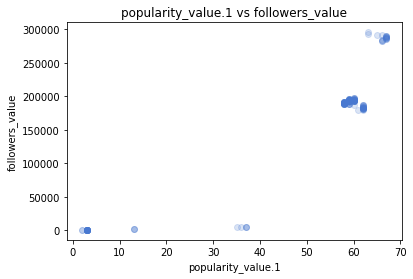

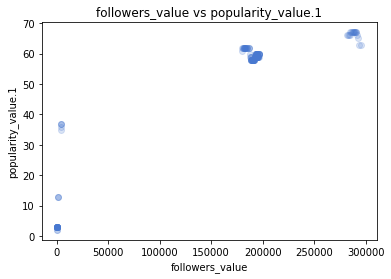

In [116]:
# index corr_list by correlation greater than 0.5
plot_index = corr_list[corr_list > 0.5].index
# plot their pair x y relationship
for plot in plot_index:
  scatter_plot(grp,plot[0],plot[1])

#### Pair init Regression 


                            OLS Regression Results                            
Dep. Variable:        followers_value   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     4223.
Date:                Tue, 29 Dec 2020   Prob (F-statistic):           2.23e-95
Time:                        07:25:20   Log-Likelihood:                -1343.3
No. Observations:                 122   AIC:                             2691.
Df Residuals:                     120   BIC:                             2696.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -5408.4685   2960.92

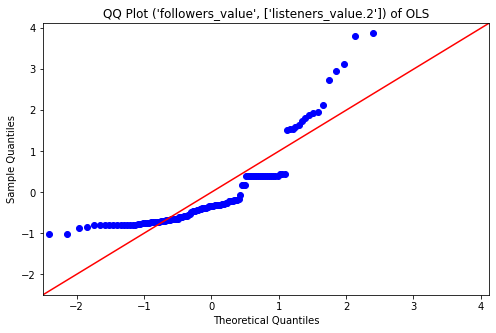

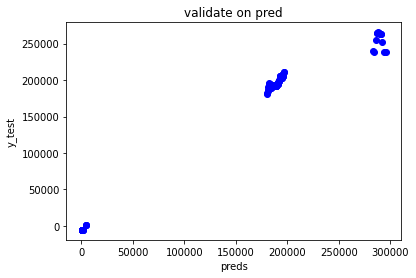

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


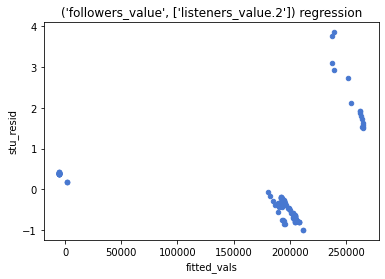

                            OLS Regression Results                            
Dep. Variable:      listeners_value.2   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     3729.
Date:                Tue, 29 Dec 2020   Prob (F-statistic):           3.16e-92
Time:                        07:25:21   Log-Likelihood:                -1597.9
No. Observations:                 122   AIC:                             3200.
Df Residuals:                     120   BIC:                             3205.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            8.505e+04   2.35e+04     

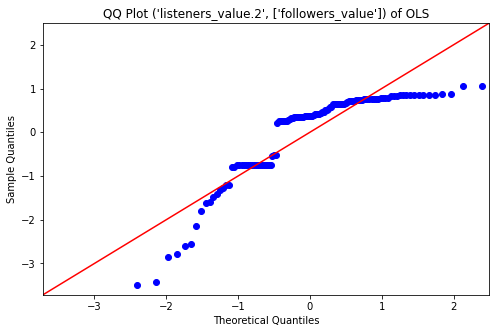

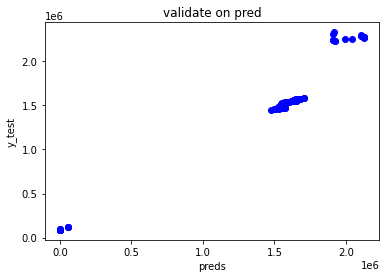

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


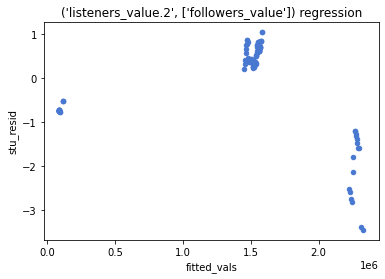

                            OLS Regression Results                            
Dep. Variable:     popularity_value.1   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     1674.
Date:                Tue, 29 Dec 2020   Prob (F-statistic):           2.50e-72
Time:                        07:25:21   Log-Likelihood:                -384.72
No. Observations:                 122   AIC:                             773.4
Df Residuals:                     120   BIC:                             779.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 9.0930      1.12

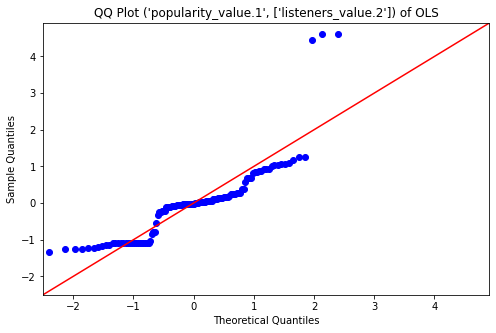

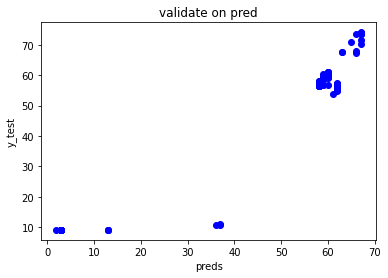

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


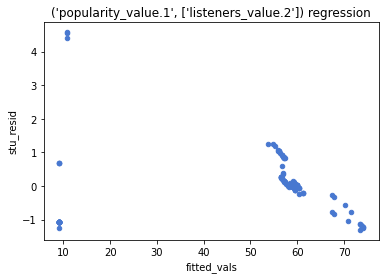

                            OLS Regression Results                            
Dep. Variable:      listeners_value.2   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     1298.
Date:                Tue, 29 Dec 2020   Prob (F-statistic):           3.44e-66
Time:                        07:25:22   Log-Likelihood:                -1656.9
No. Observations:                 122   AIC:                             3318.
Df Residuals:                     120   BIC:                             3323.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.308e+05   4.79

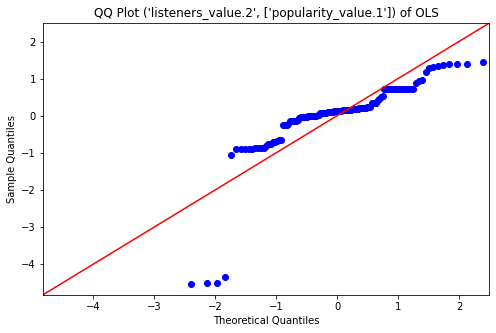

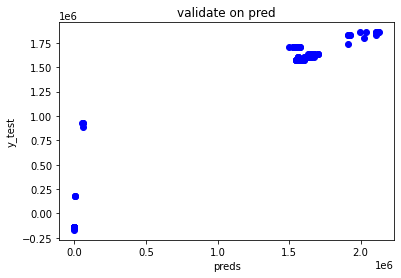

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


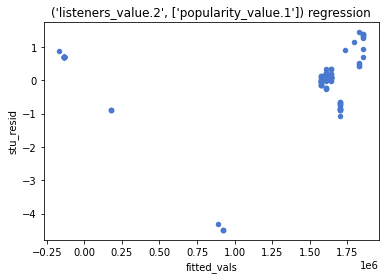

                            OLS Regression Results                            
Dep. Variable:        followers_value   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     737.3
Date:                Tue, 29 Dec 2020   Prob (F-statistic):           4.55e-53
Time:                        07:25:22   Log-Likelihood:                -1443.9
No. Observations:                 122   AIC:                             2892.
Df Residuals:                     120   BIC:                             2897.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.855e+04   7856

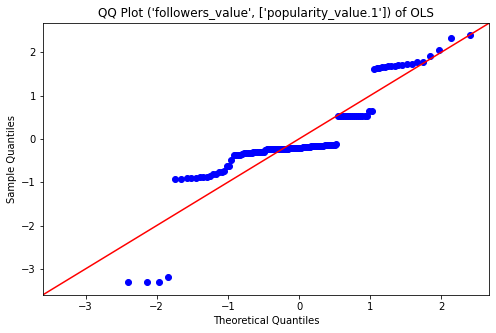

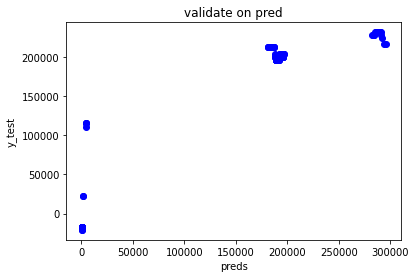

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


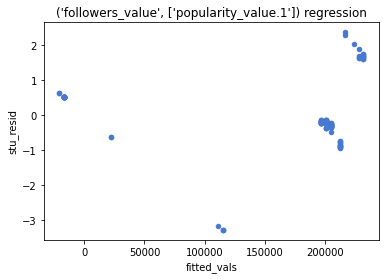

                            OLS Regression Results                            
Dep. Variable:     popularity_value.1   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     712.2
Date:                Tue, 29 Dec 2020   Prob (F-statistic):           2.70e-52
Time:                        07:25:23   Log-Likelihood:                -425.25
No. Observations:                 122   AIC:                             854.5
Df Residuals:                     120   BIC:                             860.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              14.1715      1.547     

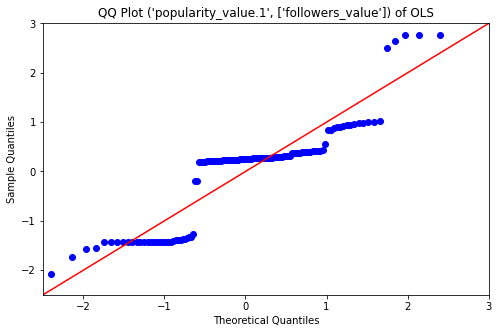

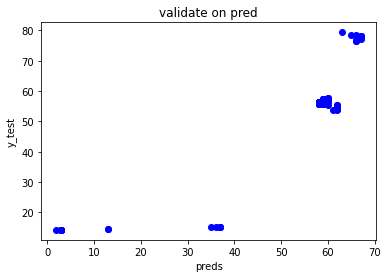

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


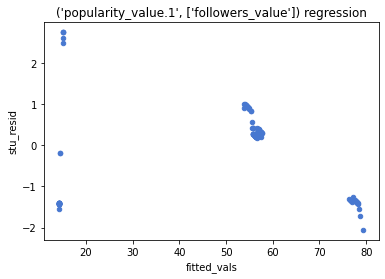

In [117]:
for plot in plot_index:
    linear_regression_initial(grp,[plot[0]],plot[1])

### Describe groupby timeseries

In [118]:
describe_cols(grp,40)

,followers_value,popularity_value.1,listeners_value.2,followers_to_listeners_ratio_value.3
count,153.000000,153.000000,1.530000e+02,153.000000
mean,163243.607843,49.830065,1.325069e+06,46.165621
std,89502.847784,21.880294,6.953453e+05,78.786436
min,334.000000,2.000000,1.620000e+02,7.650000
25%,182059.000000,58.000000,1.533155e+06,11.770000
50%,191204.000000,59.000000,1.577972e+06,12.040000
75%,194541.000000,61.000000,1.652460e+06,13.790000
max,295738.000000,67.000000,2.127363e+06,273.660000


### Plot Polularity Scores Distribution

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



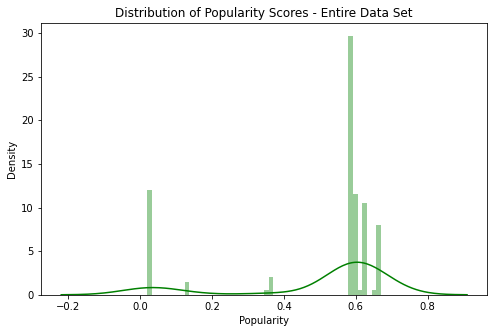

In [119]:
plot_pop_dist(grp)

### Plot Undersampling Methodology

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



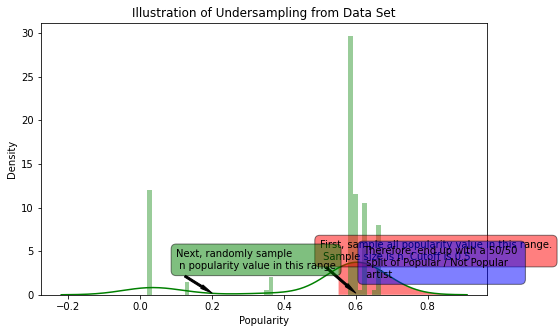

In [120]:
undersample_plot(grp)

### Plot Univariate Dists for several Independant variables

Mean value for followers feature for Popular artists: nan
Mean value for followers feature for Unpopular artists: 163243.60784313726
Mean value for listeners feature for Popular artists: nan
Mean value for listeners feature for Unpopular artists: 1325068.888888889


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2589: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning:

invalid value encountered in true_divide



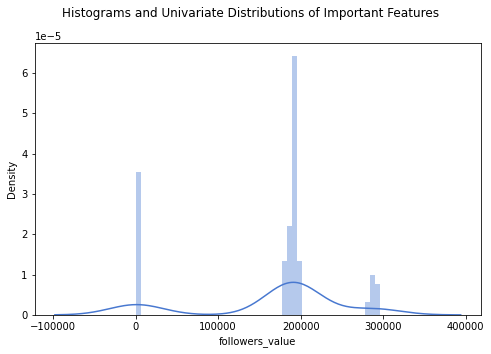

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2589: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning:

invalid value encountered in true_divide



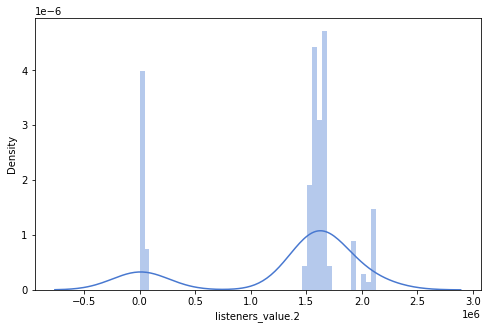

In [121]:
plot_univ_dists(grp, 70)

### Data prep

The top absolute correlations are:
followers_value     listeners_value.2                       0.986171
popularity_value.1  listeners_value.2                       0.961009
followers_value     popularity_value.1                      0.933103
popularity_value.1  followers_to_listeners_ratio_value.3    0.924755
listeners_value.2   followers_to_listeners_ratio_value.3    0.824031
followers_value     followers_to_listeners_ratio_value.3    0.784836
dtype: float64


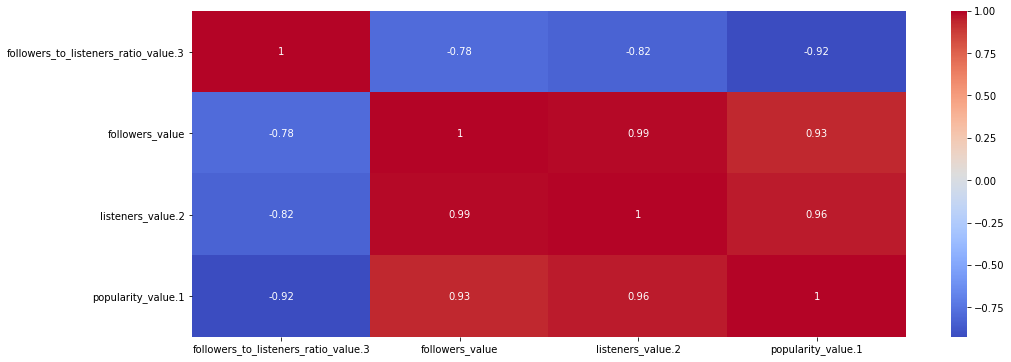

In [122]:
au_corr = get_top_abs_correlations(grp, 25)
# get unique columns from top abs correlations
train_cols = np.unique((np.asarray([(index[0],index[1]) for index in au_corr.index])).flatten())
# index grouby Chartmetric ID and timeseries with the unique top abs correlations
dtrain = grp[train_cols]
# plot newly abs correlated heatmap
plot_heatmap(dtrain)

### Simple Linear Regression on Popularity

                            OLS Regression Results                            
Dep. Variable:     popularity_value.1   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     2144.
Date:                Tue, 29 Dec 2020   Prob (F-statistic):          1.04e-102
Time:                        07:25:25   Log-Likelihood:                -292.69
No. Observations:                 122   AIC:                             593.4
Df Residuals:                     118   BIC:                             604.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


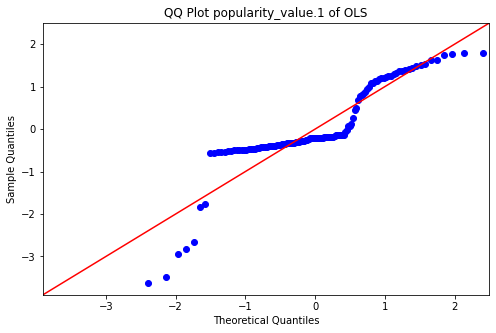

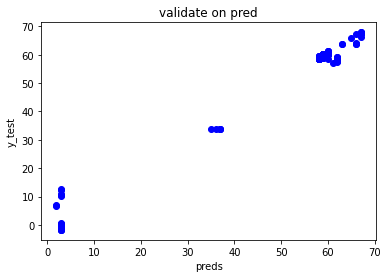

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


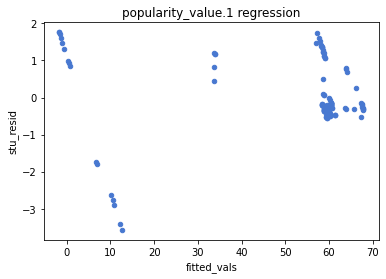

In [123]:
fitted_pop = linear_regression_initial(dtrain,dtrain.columns.drop('popularity_value.1'),Y='popularity_value.1')

#### Standardize Regression and call it the new artist scores

In [124]:
artist_scores = stats.zscore(fitted_pop['fitted_vals'])
artist_scores

array([ 0.41901509,  0.26634656,  0.34680589,  0.41114656,  0.79416691,
       -2.62863886,  0.42980779,  0.33570745,  0.41507251,  0.40621718,
        0.3332259 ,  0.37867455,  0.80108516,  0.40868312,  0.3750154 ,
        0.42320714,  0.80616398,  0.61510182,  0.31895341, -2.72778323,
        0.33163053,  0.78385258, -2.00097364,  0.35374952,  0.33002784,
       -2.13244671,  0.44358588,  0.32749361,  0.40621718,  0.34222383,
        0.3384149 ,  0.39467762, -0.92532465, -2.30515995,  0.35729367,
        0.72485943,  0.78803686,  0.40621718,  0.42320714,  0.34229685,
        0.41923744,  0.41889963, -2.69678429,  0.34745812,  0.42320714,
        0.35898317,  0.79885772,  0.35130209, -2.61158589, -2.62004628,
        0.31875869,  0.42199655,  0.3865887 ,  0.31434831,  0.42320714,
        0.4105041 ,  0.43108385,  0.43108385,  0.33742506, -2.73492172,
        0.59390193,  0.3279445 , -0.92958209,  0.37779088,  0.47037211,
       -2.73492172,  0.34999601,  0.42395607,  0.33721156,  0.78

#### Explore Regression Results

In [125]:
get_df_info(fitted_pop)

                          residuals  fitted_vals  stu_resid
followers_timestp                                          
2020-04-25T00:00:00.000Z  -1.293517    60.293517  -0.477381
2020-01-04T00:00:00.000Z   4.710314    57.289686   1.738372
2020-03-27T00:00:00.000Z  -0.872764    58.872764  -0.322099
2020-04-17T00:00:00.000Z  -1.138700    60.138700  -0.420244
2020-02-26T00:00:00.000Z  -0.674822    67.674822  -0.249047 

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, 2020-04-25T00:00:00.000Z to 2020-05-21T00:00:00.000Z
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   residuals    122 non-null    float64
 1   fitted_vals  122 non-null    float64
 2   stu_resid    122 non-null    float64
dtypes: float64(3)
memory usage: 3.8+ KB
None 

Do we have any nulls?
Looks like we have 0 nulls



,min,max,median,mean,skew
fitted_vals,-1.761807,67.910870,59.419290,5.204918e+01,-1.955395
stu_resid,-3.572096,1.757376,-0.202006,4.775077e-12,-0.760532


### Generate Multivariable Matrix shifted by 100 of one previous time step

In [126]:
MM = Multivariable_Matrix(pd.DataFrame(stats.zscore(fitted_pop),columns=fitted_pop.columns),fitted_pop,'fitted_vals')
MM

,shift_0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12,shift_13,shift_14,shift_15,shift_16,shift_17,shift_18,shift_19,shift_20,shift_21,shift_22,shift_23,shift_24,...,shift_97,shift_98,shift_99,shift_100,shift_101,shift_102,shift_103,shift_104,shift_105,shift_106,shift_107,shift_108,shift_109,shift_110,shift_111,shift_112,shift_113,shift_114,shift_115,shift_116,shift_117,shift_118,shift_119,shift_120,shift_121
followers_timestp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-25T00:00:00.000Z,0.419015,0.266347,0.346806,0.411147,0.794167,-2.628639,0.429808,0.335707,0.415073,0.406217,0.333226,0.378675,0.801085,0.408683,0.375015,0.423207,0.806164,0.615102,0.318953,-2.727783,0.331631,0.783853,-2.000974,0.353750,0.330028,...,0.701340,0.418147,0.423207,-2.712119,0.443586,-0.926501,0.252378,0.311611,-0.926666,0.328689,0.353080,0.319454,0.470372,0.408683,0.418282,0.284487,-2.022258,0.433243,0.412647,0.351848,0.411141,0.329862,0.364803,-2.110964,0.421997
2020-01-04T00:00:00.000Z,0.266347,0.346806,0.411147,0.794167,-2.628639,0.429808,0.335707,0.415073,0.406217,0.333226,0.378675,0.801085,0.408683,0.375015,0.423207,0.806164,0.615102,0.318953,-2.727783,0.331631,0.783853,-2.000974,0.353750,0.330028,-2.132447,...,0.418147,0.423207,-2.712119,0.443586,-0.926501,0.252378,0.311611,-0.926666,0.328689,0.353080,0.319454,0.470372,0.408683,0.418282,0.284487,-2.022258,0.433243,0.412647,0.351848,0.411141,0.329862,0.364803,-2.110964,0.421997,NaN
2020-03-27T00:00:00.000Z,0.346806,0.411147,0.794167,-2.628639,0.429808,0.335707,0.415073,0.406217,0.333226,0.378675,0.801085,0.408683,0.375015,0.423207,0.806164,0.615102,0.318953,-2.727783,0.331631,0.783853,-2.000974,0.353750,0.330028,-2.132447,0.443586,...,0.423207,-2.712119,0.443586,-0.926501,0.252378,0.311611,-0.926666,0.328689,0.353080,0.319454,0.470372,0.408683,0.418282,0.284487,-2.022258,0.433243,0.412647,0.351848,0.411141,0.329862,0.364803,-2.110964,0.421997,NaN,NaN
2020-04-17T00:00:00.000Z,0.411147,0.794167,-2.628639,0.429808,0.335707,0.415073,0.406217,0.333226,0.378675,0.801085,0.408683,0.375015,0.423207,0.806164,0.615102,0.318953,-2.727783,0.331631,0.783853,-2.000974,0.353750,0.330028,-2.132447,0.443586,0.327494,...,-2.712119,0.443586,-0.926501,0.252378,0.311611,-0.926666,0.328689,0.353080,0.319454,0.470372,0.408683,0.418282,0.284487,-2.022258,0.433243,0.412647,0.351848,0.411141,0.329862,0.364803,-2.110964,0.421997,NaN,NaN,NaN
2020-02-26T00:00:00.000Z,0.794167,-2.628639,0.429808,0.335707,0.415073,0.406217,0.333226,0.378675,0.801085,0.408683,0.375015,0.423207,0.806164,0.615102,0.318953,-2.727783,0.331631,0.783853,-2.000974,0.353750,0.330028,-2.132447,0.443586,0.327494,0.406217,...,0.443586,-0.926501,0.252378,0.311611,-0.926666,0.328689,0.353080,0.319454,0.470372,0.408683,0.418282,0.284487,-2.022258,0.433243,0.412647,0.351848,0.411141,0.329862,0.364803,-2.110964,0.421997,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-11T00:00:00.000Z,0.412647,0.783172,-0.927361,0.802987,0.409790,0.428571,-2.296700,0.297002,0.328689,0.408683,0.431084,0.351106,0.701340,0.418147,0.423207,-2.712119,0.443586,-0.926501,0.252378,0.311611,-0.926666,0.328689,0.353080,0.319454,0.470372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-05T00:00:00.000Z,0.783172,-0.927361,0.802987,0.409790,0.428571,-2.296700,0.297002,0.328689,0.408683,0.431084,0.351106,0.701340,0.418147,0.423207,-2.712119,0.443586,-0.926501,0.252378,0.311611,-0.926666,0.328689,0.353080,0.319454,0.470372,0.408683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-07T00:00:00.000Z,-0.927361,0.802987,0.409790,0.428571,-2.296700,0.297002,0.328689,0.408683,0.431084,0.351106,0.701340,0.418147,0.423207,-2.712

#### XGBOOST tree leaf nodes

In [127]:
pred_over90 = lin_reg_forcast(MM,Y='shift_0')

[[ 6 13  8  7  7 11  7 16  7 16]
 [12  7  9 12  1 12 11  8 14  8]
 [12 12  1  3 10 12  1 16 16 14]
 [12 16 11  3 14 13 11  7  1 16]
 [ 5 12  9 11  9  6  1 16 11 16]
 [ 6 11  8  5  5  2 12 11  1  2]
 [14 15  3  4  7 10 11  8  7 16]
 [12 16 13 12 15 13 11  7 15  2]
 [ 6  4  1  4  7  6  1 11 14  2]
 [ 9 12  6  3  7 13  3 13 16 14]
 [12  7  8 12  7 11  5  8 14 15]
 [13 16  1  7 15 14  9  7  4 13]
 [ 9 12 14 12 16 12 12  9  1 13]
 [ 9  9  6  7 14 11  1  7  5 16]
 [13  4 13  3 14 12 11  8 14 16]
 [10 12  3  9  5  8 12 11  1  8]
 [ 9  9  1  7  7 10  7 15  4  7]
 [13  7  1  3  9  2  1 16  7 12]
 [12 16 13 12 14 13 11 12  9 15]
 [ 9 11  8  5  7  2  1 11  1  2]
 [ 9 12 11  3 11 14 12 12 14  8]
 [ 6 11  1  7  1  8  1 11  1 16]
 [14  4 13 12 10  6 11 15 11 12]
 [ 6 11  3  5  1  2 12 16  4  8]
 [10 11  1  4  5 11  3 12  4  8]
 [ 6  4  8  5 11 10  5 12 11 13]
 [10  4  6  5 11  8  7 15  9  8]
 [12 16  8  3  7 12  9  8  5 15]
 [ 9 11 11  3 11 10 12  9 11 12]
 [12 16 13 11  1 13 12 13 15 16]
 [12  4  9

### Artist Scores for next 90 time series step based from group by Chartmetric ID and Time series data


In [128]:
pred_over90

array([ 0.38292086,  0.16196615,  0.23992042,  0.35030305,  0.328123  ,
       -0.6127702 ,  0.3039647 ,  0.34224287, -0.31377545,  0.3716443 ,
        0.38534304,  0.35267165,  0.32550994,  0.2714478 ,  0.45391953,
       -0.4826619 ,  0.41507742,  0.14722653,  0.3870528 , -0.41628405,
        0.25479078, -0.6724302 ,  0.6113838 , -0.50277936, -0.65759236,
        0.21169846,  0.01952904,  0.47417656,  0.3366738 ,  0.34883216,
        0.51284873, -0.2131356 ,  0.30670768,  0.30611613,  0.58740205,
        0.3585086 ,  0.42737025,  0.37422904,  0.42259973, -0.41336325,
        0.47216278,  0.5341534 , -0.440405  ,  0.37721774,  0.13955775,
        0.26447162,  0.42622903,  0.3608241 ,  0.33046785,  0.54997295,
        0.43493405,  0.42539784,  0.34767887,  0.0136475 ,  0.4536135 ,
        0.3879834 ,  0.31908605,  0.45819357,  0.17022014,  0.18136318,
       -0.01026586,  0.39373952,  0.4755303 ,  0.36979988,  0.36358085,
        0.23388676,  0.30585316,  0.22838369,  0.4208798 ,  0.27

### Preliminary Logistic Regression <- FIX ME

In [129]:
basic_logistic_regression(pd.DataFrame(stats.zscore(dtrain),columns=dtrain.columns),cutoff=np.mean(stats.zscore(dtrain))*2)

KeyError: ignored

### Google API services integrations

In [ ]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('chartmetric_cred.json', scope)
gc = gspread.authorize(credentials)

In [ ]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1zr1gp_O1xlfGaPxE8bPVUXtSsiNRbzeS53-axQrOY5s/edit#gid=289689074')

In [ ]:
sheet = wb.worksheet('grouped')

In [ ]:
import os 
import psutil

process = psutil.Process(os.getpid())
process.memory_info()


In [ ]:
import resource
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss